# 기초세팅

In [1]:
%cd drive/MyDrive/Colab\ Notebooks/HouseholdDebt

/content/drive/MyDrive/Colab Notebooks/HouseholdDebt


# 한글세팅

In [2]:
!sudo apt-get update -qq
!sudo apt-get install fonts-nanum* -qq

In [3]:
%matplotlib inline  

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도

In [4]:
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)

NanumBarunGothic


In [5]:
plt.rc('font', family=font_name)
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

In [6]:
import seaborn as sns

In [7]:
sns.set(font=font_name, 
        rc={"axes.unicode_minus":False},
        style='darkgrid')

In [8]:
import pandas as pd

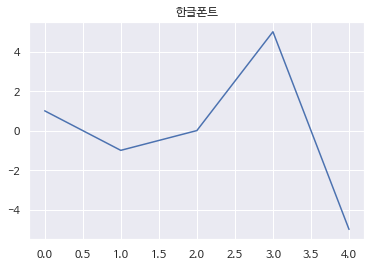

In [9]:
pd.Series([1, -1, 0, 5, -5]).plot(title="한글폰트")
None

In [10]:
!pip install statsmodels --upgrade

# 2030 신용대출 quarterly


In [575]:
import math
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import *
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

## Data load

In [576]:
quarterly_index = pd.date_range(start='2010-01-01', end='2021-09-30', freq='Q')

In [577]:
df = pd.DataFrame(index=quarterly_index)

### macro data load

In [578]:
df_macro = pd.read_csv('data/all_monthly_macro_data.csv', index_col=0)

In [579]:
df_macro.index = pd.date_range(start='2010-01-31', end='2021-12-31', freq='M')

In [580]:
df['credit_loan_ir'] = df_macro['credit_loan_ir']

In [581]:
df['kospi'] = df_macro['kospi']

In [582]:
df_crypto = pd.read_csv('data/crypto_monthly.csv', index_col=0)

In [583]:
df_crypto.index = pd.date_range(start='2016-01-31', end='2021-12-31', freq='M')

In [584]:
df['btc_krw'] = df_crypto['btc_krw']

### Loan data load

In [585]:
df_loan = pd.read_csv('data/house_loan_v2.csv')

In [586]:
df['credit_loan_2030'] = list(df_loan[(df_loan['연령대'].isin(['20대', '30대'])) & (df_loan['상품구분(KFB)명'] == '신용대출')].groupby('기준분기').sum()['총금액 <Sum>'] / df_loan[(df_loan['연령대'].isin(['20대', '30대'])) & (df_loan['상품구분(KFB)명'] == '신용대출')].groupby('기준분기').sum()['소득추정금액 <Sum>'])

### Transaction data load

In [587]:
df_transaction = pd.DataFrame(index=pd.date_range(start='2010-01-31', end='2021-12-31', freq='M'))

In [588]:
df_transaction['krx_transaction'] = df_macro['krx_transaction']
df_transaction['crypto_krw_transaction'] = df_crypto['crypto_krw_transaction']

In [589]:
df_transaction = df_transaction.fillna(0)

In [590]:
df_transaction['date'] = pd.date_range(start='2010-01-31', end='2021-12-31', freq='M')

In [591]:
df_transaction['q'] = df_transaction.date.apply(lambda x: f'{x.year}Q{math.ceil(x.month / 3)}')

In [592]:
df_transaction

,krx_transaction,crypto_krw_transaction,date,q
2010-01-31,258243163.0,0.000000e+00,2010-01-31,2010Q1
2010-02-28,163736548.0,0.000000e+00,2010-02-28,2010Q1
2010-03-31,193438213.0,0.000000e+00,2010-03-31,2010Q1
2010-04-30,209766895.0,0.000000e+00,2010-04-30,2010Q2
2010-05-31,198346507.0,0.000000e+00,2010-05-31,2010Q2
...,...,...,...,...
2021-08-31,834978945.0,5.378122e+13,2021-08-31,2021Q3
2021-09-30,674180430.0,4.564198e+13,2021-09-30,2021Q3
2021-10-31,607106382.0,6.369000e+13,2021-10-31,2021Q4
2021-11-30,756235829.0,6.480509e+13,2021-11-30,2021Q4


In [593]:
df_transaction_quarterly = df_transaction.groupby('q').sum()

In [594]:
df_transaction_quarterly.index = pd.date_range(start='2010-01-31', end='2021-12-31', freq='Q')

In [595]:
df['krx_transaction'] = df_transaction_quarterly['krx_transaction']
df['crypto_krw_transaction'] = df_transaction_quarterly['crypto_krw_transaction']

In [596]:
df

,credit_loan_ir,kospi,btc_krw,credit_loan_2030,krx_transaction,crypto_krw_transaction
2010-03-31,7.42,1692.85,NaN,0.481912,6.154179e+08,0.000000e+00
2010-06-30,7.06,1698.29,NaN,0.496228,5.866367e+08,0.000000e+00
2010-09-30,7.22,1872.81,NaN,0.502845,5.562210e+08,0.000000e+00
2010-12-31,7.10,2051.00,NaN,0.512095,6.738413e+08,0.000000e+00
2011-03-31,7.76,2106.70,NaN,0.506489,6.949982e+08,0.000000e+00
2011-06-30,7.53,2100.69,NaN,0.534508,6.998273e+08,0.000000e+00
2011-09-30,8.27,1769.65,NaN,0.553714,7.636986e+08,0.000000e+00
2011-12-31,7.90,1825.74,NaN,0.580176,7.566240e+08,0.000000e+00
2012-03-31,8.14,2014.04,NaN,0.598876,7.049570e+08,0.000000e+00
2012-06-30,7.89,1854.01,NaN,0.616404,4.705143e+08,0.000000e+00


### Visualization

In [597]:
from sklearn.preprocessing import StandardScaler

In [598]:
def visualize(df_list):
  df_scaled_list = map(lambda df: pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index=df.index), df_list)

  plt.figure(figsize=(15, 8))
  for df in df_scaled_list:
    sns.lineplot(data=df)
  plt.show()
  None

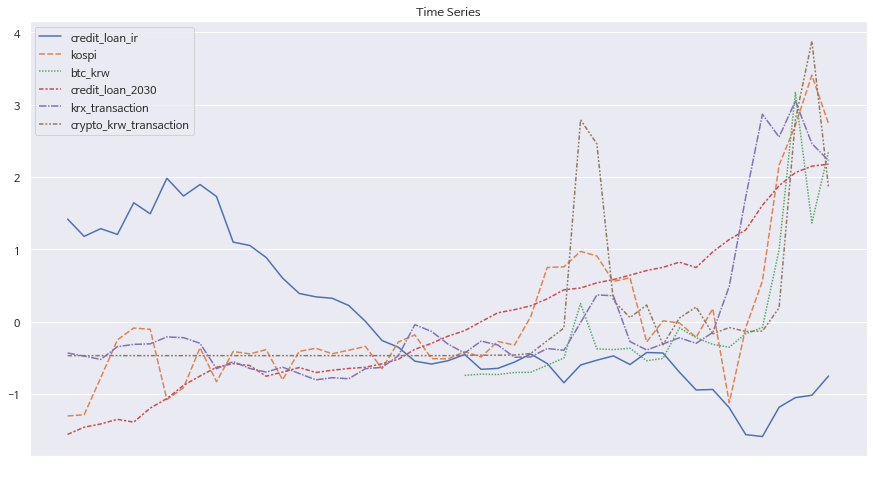

In [599]:
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index=df.index)
plt.figure(figsize = (15,8))
ax = sns.lineplot(data=df_scaled)
ax.set_title('Time Series')
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 12 != 0:
        xticks[i].set_visible(False)
plt.show()
None

### Select variable and cut

In [600]:
df = df[26:]

In [601]:
df = df[['credit_loan_2030', 'krx_transaction', 'crypto_krw_transaction']]
#df = df[['credit_loan_ir', 'credit_loan_2030', 'krx_transaction', 'crypto_krw_transaction']]

In [602]:
df

,credit_loan_2030,krx_transaction,crypto_krw_transaction
2016-09-30,0.725605,6.893853e+08,2.924863e+11
2016-12-31,0.731873,5.763678e+08,4.718544e+11
2017-03-31,0.739673,5.790453e+08,1.641932e+12
2017-06-30,0.753709,6.568032e+08,1.125846e+13
2017-09-30,0.771654,6.403596e+08,2.078662e+13
2017-12-31,0.775354,8.958439e+08,1.776622e+14
2018-03-31,0.785686,1.150695e+09,1.594810e+14
2018-06-30,0.792134,1.143851e+09,4.158319e+13
2018-09-30,0.801074,7.203044e+08,2.868309e+13
2018-12-31,0.810351,6.431874e+08,3.809729e+13


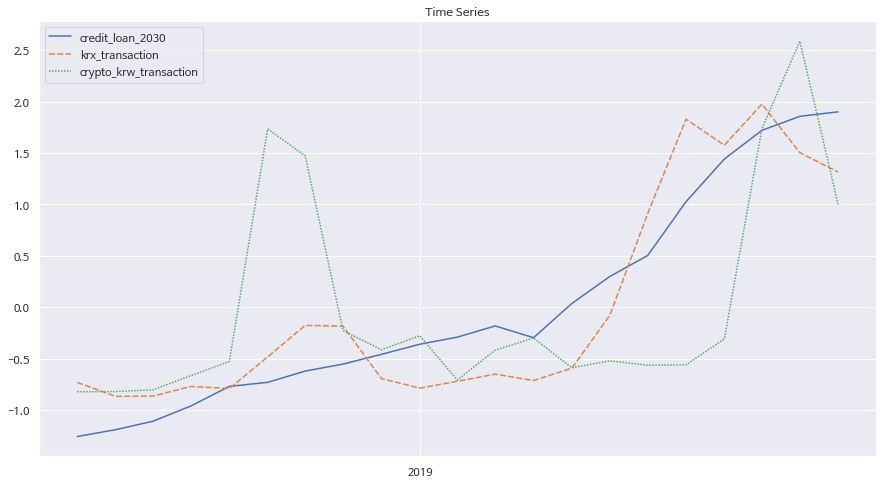

In [603]:
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns, index=df.index)
plt.figure(figsize = (15,8))
ax = sns.lineplot(data=df_scaled)
ax.set_title('Time Series')
xticks=ax.xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 3 != 0:
        xticks[i].set_visible(False)
plt.show()
None

### log

In [604]:
df.columns

Index(['credit_loan_2030', 'krx_transaction', 'crypto_krw_transaction'], dtype='object')

In [605]:
df_log = df.copy()
for col in df.columns:
  #if col in ['credit_loan_ir']:
  #  print(col)
  #  continue
  df_log[col] = df[col].apply(np.log)

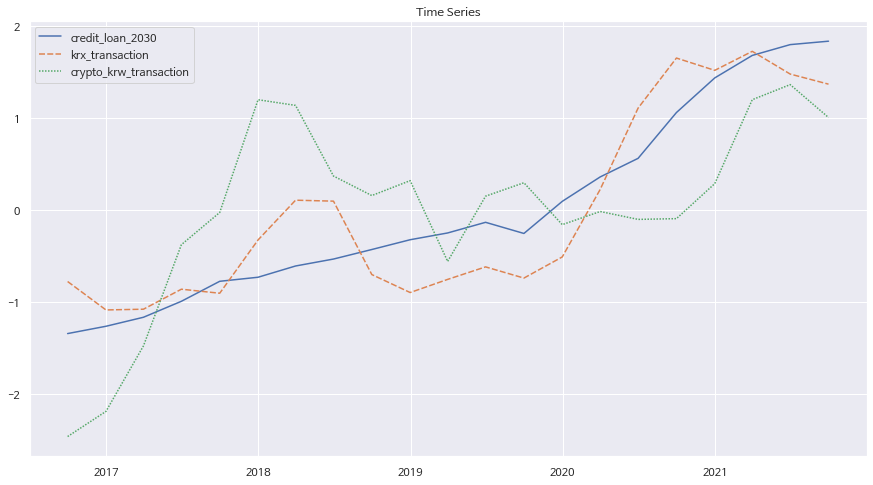

In [606]:
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df_log), columns=df_log.columns, index=df_log.index)
plt.figure(figsize = (15,8))
ax = sns.lineplot(data=df_scaled)
ax.set_title('Time Series')
plt.show()
None

In [607]:
df_log

,credit_loan_2030,krx_transaction,crypto_krw_transaction
2016-09-30,-0.320749,20.351311,26.401684
2016-12-31,-0.312148,20.172256,26.879936
2017-03-31,-0.301547,20.176891,28.126895
2017-06-30,-0.282749,20.302895,30.052141
2017-09-30,-0.259219,20.277540,30.665331
2017-12-31,-0.254435,20.613277,32.810905
2018-03-31,-0.241198,20.863632,32.702946
2018-06-30,-0.233024,20.857666,31.358717
2018-09-30,-0.221802,20.395185,30.987329
2018-12-31,-0.210288,20.281947,31.271164


## Diff

In [608]:
def convert_log_data_to_freq_over_freq(df, freq):
  a = np.array(df)
  df_qoq = pd.DataFrame(data=(a[freq:] - a[:-freq]) ,index=df.index[freq:], columns=df.columns)
  return df_qoq

### QOQ

In [609]:
df_log_qoq = convert_log_data_to_freq_over_freq(df_log, 1)

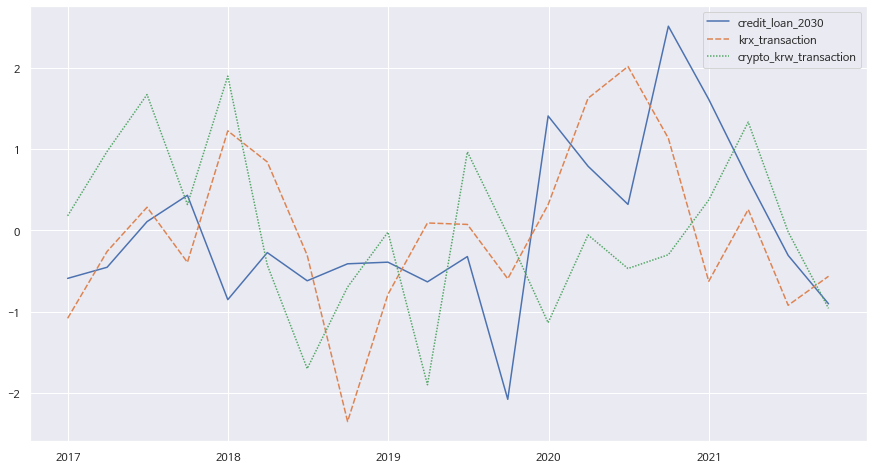

In [610]:
visualize([df_log_qoq])

### YOY

In [611]:
df_log_yoy = convert_log_data_to_freq_over_freq(df_log, 4)

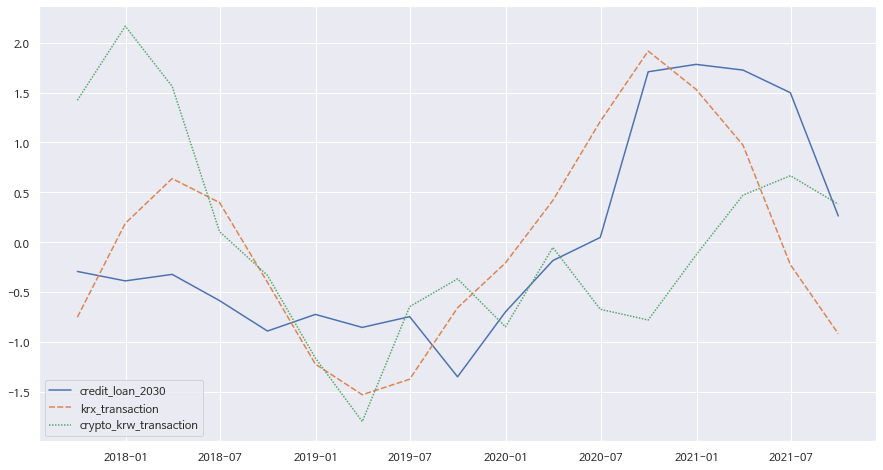

In [612]:
visualize([df_log_yoy])

## Unit root test

In [613]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

### Original Series

In [614]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "credit_loan_2030" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.2793
 No. Lags Chosen       = 8
 Critical value 1%     = -4.138
 Critical value 5%     = -3.155
 Critical value 10%    = -2.714
 => P-Value = 0.9764. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "krx_transaction" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.8331
 No. Lags Chosen       = 8
 Critical value 1%     = -4.138
 Critical value 5%     = -3.155
 Critical value 10%    = -2.714
 => P-Value = 0.9922. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "crypto_krw_transaction" 
    -------------------------------------------

### Log Series

In [615]:
for name, column in df_log.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "credit_loan_2030" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.0649
 No. Lags Chosen       = 8
 Critical value 1%     = -4.138
 Critical value 5%     = -3.155
 Critical value 10%    = -2.714
 => P-Value = 0.9528. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "krx_transaction" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.8826
 No. Lags Chosen       = 6
 Critical value 1%     = -4.012
 Critical value 5%     = -3.104
 Critical value 10%    = -2.691
 => P-Value = 0.9929. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "crypto_krw_transaction" 
    ------------------------------------------

### QOQ

In [616]:
for name, column in df_log_qoq.iteritems():
  adfuller_test(column, name=column.name)
  print('\n')

    Augmented Dickey-Fuller Test on "credit_loan_2030" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.2801
 No. Lags Chosen       = 8
 Critical value 1%     = -4.223
 Critical value 5%     = -3.189
 Critical value 10%    = -2.73
 => P-Value = 0.0158. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "krx_transaction" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.6979
 No. Lags Chosen       = 8
 Critical value 1%     = -4.223
 Critical value 5%     = -3.189
 Critical value 10%    = -2.73
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "crypto_krw_transaction" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-

### YOY

In [617]:
for name, column in df_log_yoy.iteritems():
  adfuller_test(column, name=column.name)
  print('\n')

    Augmented Dickey-Fuller Test on "credit_loan_2030" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.5968
 No. Lags Chosen       = 3
 Critical value 1%     = -4.069
 Critical value 5%     = -3.127
 Critical value 10%    = -2.702
 => P-Value = 0.0058. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "krx_transaction" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.2102
 No. Lags Chosen       = 4
 Critical value 1%     = -4.138
 Critical value 5%     = -3.155
 Critical value 10%    = -2.714
 => P-Value = 0.2026. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "crypto_krw_transaction" 
    -----------------------------------------------
 Null Hypothesi

### Varialbe re-seclection

## Granger's causality

In [618]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', maxlag=12, verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [619]:
grangers_causation_matrix(df_log_qoq, variables = df_log_qoq.columns, maxlag=5)

,credit_loan_2030_x,krx_transaction_x,crypto_krw_transaction_x
credit_loan_2030_y,1.0000,0.0505,0.0394
krx_transaction_y,0.0162,1.0000,0.2395
crypto_krw_transaction_y,0.0016,0.0544,1.0000


## Reorder variable

In [ ]:
df.columns

Index(['credit_loan_2030', 'krx_transaction', 'crypto_krw_transaction',
       'credit_loan_ir'],
      dtype='object')

In [ ]:
df_dff = df_diff[['credit_loan_ir', 'credit_loan_2030', 'krx_transaction', 'crypto_krw_transaction']]

In [ ]:
df_diff

,credit_loan_2030,krx_transaction,crypto_krw_transaction,credit_loan_ir
2016-12-31,0.008602,-0.179054,0.478253,0.029716
2017-03-31,0.010601,0.004635,1.246958,0.037573
2017-06-30,0.018798,0.126004,1.925246,-0.044353
2017-09-30,0.023530,-0.025355,0.613190,-0.095083
2017-12-31,0.004783,0.335736,2.145574,0.088257
2018-03-31,0.013237,0.250355,-0.107959,0.022574
2018-06-30,0.008174,-0.005966,-1.344229,0.019890
2018-09-30,0.011222,-0.462482,-0.371388,-0.040184
2018-12-31,0.011514,-0.113238,0.283836,0.055385
2019-03-31,0.007976,0.082766,-1.536971,-0.002157


## Cointegration rank

In [620]:
def cointegration_test(df, det_order=-1, k_ar_diff=5, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df, det_order=det_order,k_ar_diff=k_ar_diff)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [621]:
cointegration_test(df_log, -1, 4)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
credit_loan_2030 ::  nan       > 24.2761   =>   False
krx_transaction ::  420.4     > 12.3212   =>   True
crypto_krw_transaction ::  6.81      > 4.1296    =>   True


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/vecm.py:726: RuntimeWarning: invalid value encountered in log
  tmp = np.log(iota - a)[i:]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/vecm.py:728: RuntimeWarning: invalid value encountered in log
  lr2[i] = -t * np.log(1 - a[i])


In [622]:
rank_test = select_coint_rank(df_log, -1, 4, method="trace",
                              signif=0.05)
rank_test.rank

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/vecm.py:726: RuntimeWarning: invalid value encountered in log
  tmp = np.log(iota - a)[i:]
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/vecm.py:728: RuntimeWarning: invalid value encountered in log
  lr2[i] = -t * np.log(1 - a[i])


3

In [623]:
rank_test.summary()

r_0,r_1,test statistic,critical value
0,3,nan,24.28
1,3,420.4,12.32
2,3,6.812,4.130


## VECM: endog: 3 , no exog

### Lag order selection

In [479]:
lag_order = select_order(data=df_log, maxlags=10, deterministic="n", seasons=4)
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,-13.30,-12.67,4.548e-06,-14.00
1,-inf*,-inf*,inf,-inf*
2,-189.8,-188.6,-7.131e-84*,-191.1
3,-189.6,-188.1,-2.583e-85,-191.2
4,-189.9,-188.1,-1.300e-86,-191.8
5,-186.8,-184.8,-2.649e-86,-189.0
6,-186.6,-184.4,-3.436e-87,-189.1
7,-185.2,-182.6,-1.826e-87,-188.0
8,-181.5,-178.7,-9.625e-87,-184.6
9,-178.6,-175.5,-2.287e-86,-182.0


In [506]:
lag_order = select_order(data=df_log, maxlags=7, deterministic="n", seasons=0)
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,-12.51,-11.99,3.912e-06,-12.62
1,-12.07,-11.15,8.418e-06,-12.25
2,-13.79,-12.48,4.585e-06,-14.06
3,-inf*,-inf*,inf,-inf*
4,-186.4,-184.3,-6.149e-82*,-186.8
5,-186.1,-183.6,-3.622e-83,-186.6
6,-186.6,-183.7,-2.149e-84,-187.2
7,-182.6,-179.3,-1.621e-83,-183.2


### Parameter estimation

In [481]:
pd.date_range('2016-09-30', '2021-9-30', freq='Q')

DatetimeIndex(['2016-09-30', '2016-12-31', '2017-03-31', '2017-06-30',
               '2017-09-30', '2017-12-31', '2018-03-31', '2018-06-30',
               '2018-09-30', '2018-12-31', '2019-03-31', '2019-06-30',
               '2019-09-30', '2019-12-31', '2020-03-31', '2020-06-30',
               '2020-09-30', '2020-12-31', '2021-03-31', '2021-06-30',
               '2021-09-30'],
              dtype='datetime64[ns]', freq='Q-DEC')

In [510]:
model = VECM(df_log,
             dates=pd.date_range('2016-09-30', '2021-09-30', freq='Q'),
             freq='Q',
             k_ar_diff=3,
             coint_rank=2,
             deterministic='n',
             seasons=0)

In [511]:
vecm_res = model.fit()

In [512]:
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.credit_loan_2030,-0.5357,0.181,-2.966,0.003,-0.890,-0.182
L1.krx_transaction,0.0354,0.008,4.176,0.000,0.019,0.052
L1.crypto_krw_transaction,0.0010,0.002,0.484,0.629,-0.003,0.005
L2.credit_loan_2030,-0.3994,0.152,-2.622,0.009,-0.698,-0.101
L2.krx_transaction,-0.0160,0.010,-1.524,0.127,-0.036,0.005
L2.crypto_krw_transaction,0.0072,0.002,3.921,0.000,0.004,0.011
L3.credit_loan_2030,-0.2500,0.148,-1.693,0.091,-0.539,0.039
L3.krx_transaction,0.0517,0.010,5.196,0.000,0.032,0.071
L3.crypto_krw_transaction,-0.0045,0.002,-2.375,0.018,-0.008,-0.001
,coef,std err,z,P>|z|,[0.025,0.975]


### Forecasts

In [513]:
vecm_res.predict(steps=5)

array([[ 0.04655653, 21.43641511, 31.76517308],
       [ 0.05413383, 21.51954083, 31.02371246],
       [ 0.09453972, 21.71099424, 30.09708932],
       [ 0.13179859, 21.93318798, 30.03193218],
       [ 0.1797182 , 22.2383957 , 30.43928053]])

In [514]:
vecm_res.predict(steps=5, alpha=0.05)
for text, vaĺues in zip(("forecast", "lower", "upper"), vecm_res.predict(steps=5, alpha=0.05)):
    print(text+":", vaĺues, sep="\n")

forecast:
[[ 0.04655653 21.43641511 31.76517308]
 [ 0.05413383 21.51954083 31.02371246]
 [ 0.09453972 21.71099424 30.09708932]
 [ 0.13179859 21.93318798 30.03193218]
 [ 0.1797182  22.2383957  30.43928053]]
lower:
[[3.42483988e-02 2.11139363e+01 3.08247995e+01]
 [3.04791520e-02 2.08870863e+01 3.00506581e+01]
 [5.72783876e-02 2.08170043e+01 2.90683927e+01]
 [7.81502755e-02 2.09031265e+01 2.87696234e+01]
 [1.12464975e-01 2.10841561e+01 2.88634118e+01]]
upper:
[[ 0.05886466 21.75889396 32.70554672]
 [ 0.07778851 22.15199538 31.99676681]
 [ 0.13180105 22.60498418 31.12578593]
 [ 0.1854469  22.96324946 31.294241  ]
 [ 0.24697142 23.39263534 32.01514925]]


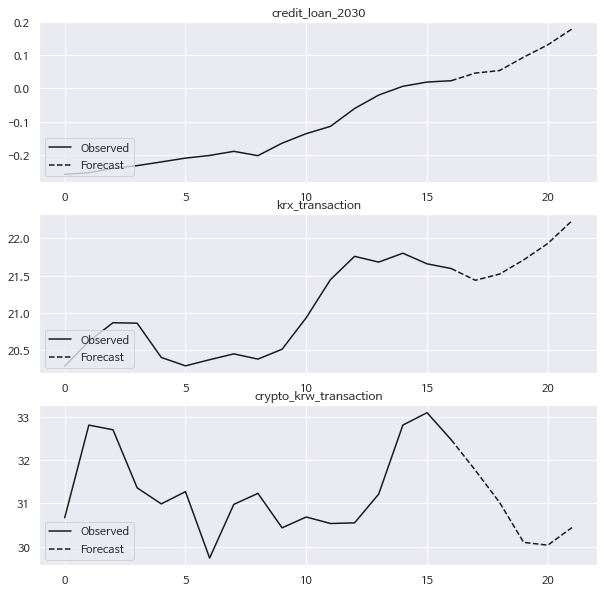

In [515]:
vecm_res.plot_forecast(steps=5, plot_conf_int=False)

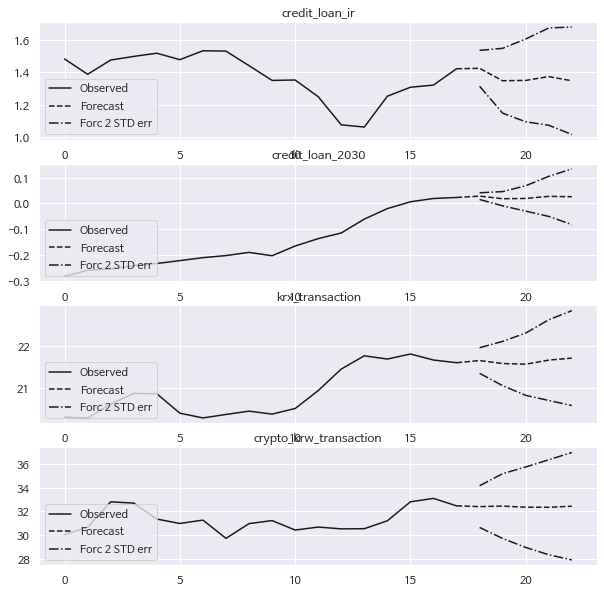

In [ ]:
vecm_res.plot_forecast(steps=5, plot_conf_int=True)

### Structural analysis

#### Granger causality

In [516]:
granger_results = vecm_res.test_granger_causality(caused="credit_loan_2030", causing='credit_loan_ir', signif=0.05)
granger_results.summary()

ValueError: ignored

In [517]:
granger_results = vecm_res.test_granger_causality(caused="credit_loan_2030", causing='krx_transaction', signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
32.00,9.117,0.009,"(4, 3)"


In [518]:
granger_results = vecm_res.test_granger_causality(caused="credit_loan_2030", causing='crypto_krw_transaction', signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
23.18,9.117,0.014,"(4, 3)"


In [519]:
granger_results = vecm_res.test_granger_causality(caused="krx_transaction", causing='credit_loan_2030', signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
16.93,9.117,0.021,"(4, 3)"


In [520]:
granger_results = vecm_res.test_granger_causality(caused="crypto_krw_transaction", causing='credit_loan_2030', signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
28.08,9.117,0.010,"(4, 3)"


#### Instantaneous causality

In [ ]:
inst_caus_base_rate = vecm_res.test_inst_causality(causing="crypto_krw_transaction")
inst_caus_base_rate.summary()

Test statistic,Critical value,p-value,df
2.655,7.815,0.448,3


#### Impulse response analysis

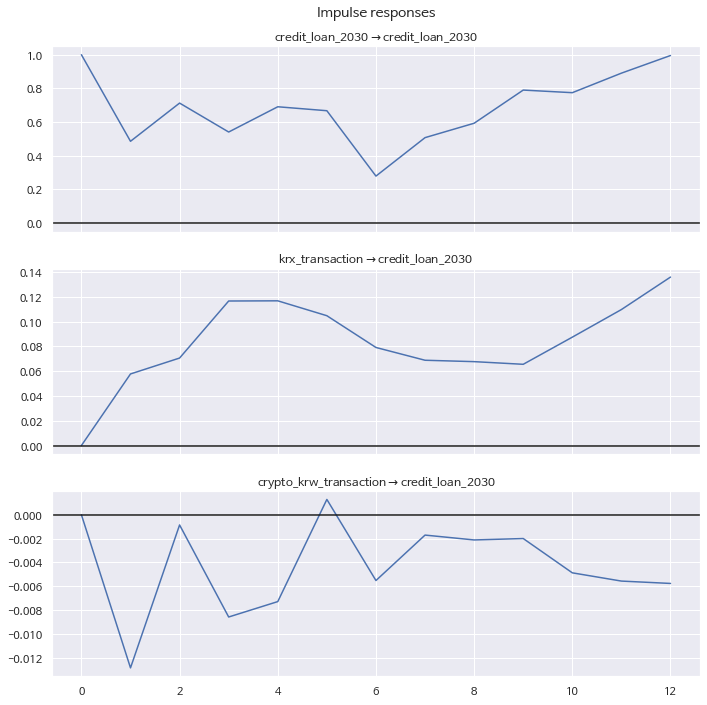

In [521]:
num_periods = 12
ir = vecm_res.irf(periods=num_periods)
#ir.plot(orth=False, plot_stderr=False, figsize=(15, 15))
ir.plot(orth=False, plot_stderr=False, response='credit_loan_2030')
None

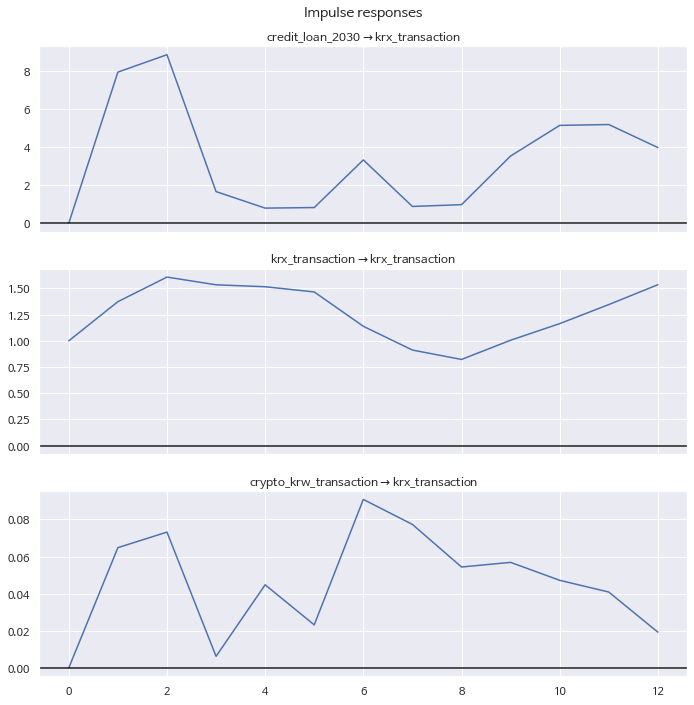

In [522]:
num_periods = 12
ir = vecm_res.irf(periods=num_periods)
#ir.plot(orth=False, plot_stderr=False, figsize=(15, 15))
ir.plot(orth=False, plot_stderr=False, response='krx_transaction')
None

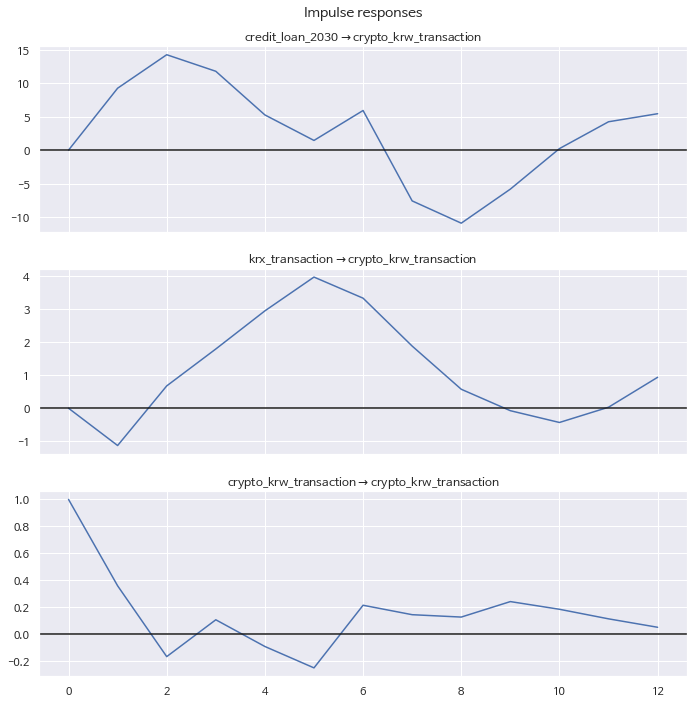

In [523]:
num_periods = 12
ir = vecm_res.irf(periods=num_periods)
#ir.plot(orth=False, plot_stderr=False, figsize=(15, 15))
ir.plot(orth=False, plot_stderr=False, response='crypto_krw_transaction')
None

### Diagnostics

#### Testing for nonormality

In [ ]:
norm_test = vecm_res.test_normality()
norm_test.summary()

Test statistic,Critical value,p-value,df
13.73,15.51,0.089,8


#### Checking for residual autocorrelation

In [ ]:
white_test = vecm_res.test_whiteness(nlags=12, adjusted=True)
white_test.summary()

Test statistic,Critical value,p-value,df
176.6,186.1,0.124,156


## VAR: endog: 3

### Lag order selection

In [629]:
model = VAR(df_log_qoq, dates=pd.date_range('2016-09-30', '2021-9-30', freq='Q'), freq='Q')
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -10.998796410607554
BIC :  -10.402308634291908
FPE :  1.7045535076700494e-05
HQIC:  -10.897846979632293 

Lag Order = 2
AIC :  -10.09465911068494
BIC :  -9.05589205980608
FPE :  4.701467420722846e-05
HQIC:  -9.951427141147693 

Lag Order = 3
AIC :  -10.463612598037075
BIC :  -8.993236108526105
FPE :  4.80511633359141e-05
HQIC:  -10.317454275302556 

Lag Order = 4
AIC :  -19.092898389130603
BIC :  -17.209713378671136
FPE :  3.5213096454391655e-08
HQIC:  -18.99646386650675 

Lag Order = 5
AIC :  -191.24992023045453
BIC :  -188.98415958692746
FPE :  -4.3233000388334184e-82
HQIC:  -191.27405531556562 

Lag Order = 6
AIC :  -205.2695401489722
BIC :  -202.66766387839579
FPE :  -5.953951505655656e-91
HQIC:  -205.51039135857079 

Lag Order = 7
AIC :  -204.86322032813626
BIC :  -201.99501589794693
FPE :  -2.4476601464046444e-92
HQIC:  -205.4527654830016 

Lag Order = 8
AIC :  -204.12686863431006
BIC :  -201.09620207313506
FPE :  -1.91832168175451e-93
HQIC:  -205.24892996724

In [630]:
x = model.select_order(maxlags=4)
x.summary()

,AIC,BIC,FPE,HQIC
0,-11.01,-10.86,1.655e-05,-11.00
1,-10.70,-10.12,2.326e-05,-10.67
2,-10.12,-9.104,4.876e-05,-10.07
3,-11.76,-10.31,1.499e-05,-11.68
4,-19.09*,-17.21*,3.521e-08*,-19.00*


### Parameter estimation

In [635]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 27, Feb, 2022
Time:                     07:25:28
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -8.99324
Nobs:                     17.0000    HQIC:                  -10.3175
Log likelihood:           46.5748    FPE:                4.80512e-05
AIC:                     -10.4636    Det(Omega_mle):     1.19939e-05
--------------------------------------------------------------------
Results for equation credit_loan_2030
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                             0.017443         0.007262            2.402           0.016
L1.credit_loan_2030               0.088905         0.273852            0.325           0.745
L

### Diagnostics

#### Testing for nonormality

In [636]:
norm_test = model_fitted.test_normality()
norm_test.summary()

Test statistic,Critical value,p-value,df
2.649,12.59,0.851,6


#### Checking for residual autocorrelation

In [637]:
whiteness_test = model_fitted.test_whiteness()
whiteness_test.summary()

Test statistic,Critical value,p-value,df
53.31,82.53,0.803,63


### Forecasts

In [644]:
model_fitted.forecast(y=df_log_qoq.values[-4:],steps=12)

array([[ 0.00185869, -0.16323847, -0.43934412],
       [-0.00098838, -0.12670304, -0.09696444],
       [ 0.01258752,  0.02416237, -0.65607151],
       [ 0.01815153,  0.17862915, -0.27943887],
       [ 0.0180243 ,  0.21308467,  0.11982025],
       [ 0.02807592,  0.15247136, -0.11720901],
       [ 0.03102282,  0.1255843 ,  0.12801526],
       [ 0.02440582,  0.12191901,  0.46109168],
       [ 0.0212676 ,  0.06645843,  0.28492876],
       [ 0.01820902,  0.00490646,  0.20102809],
       [ 0.01333391, -0.01550107,  0.19338956],
       [ 0.01199143, -0.00792961,  0.01510826]])

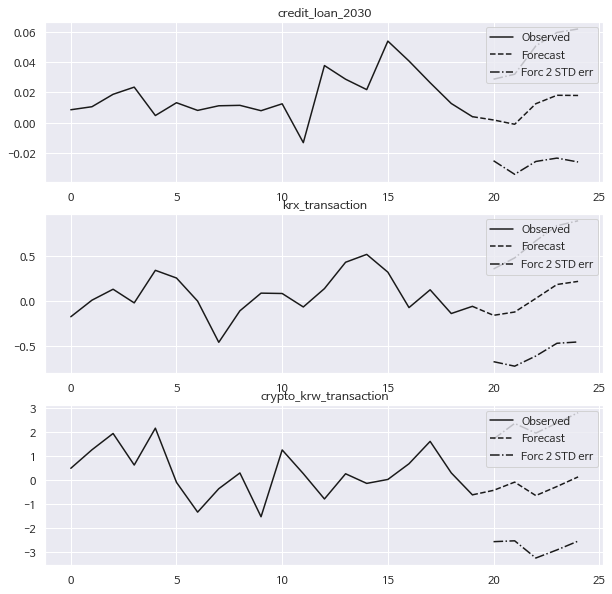

In [649]:
model_fitted.plot_forecast(steps=5)
None

### Structural analysis

#### Granger causality

In [ ]:
granger_results = vecm_res.test_granger_causality(caused="credit_loan_2030", causing='credit_loan_ir', signif=0.05)
granger_results.summary()

ValueError: ignored

In [ ]:
granger_results = vecm_res.test_granger_causality(caused="credit_loan_2030", causing='krx_transaction', signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
32.00,9.117,0.009,"(4, 3)"


In [ ]:
granger_results = vecm_res.test_granger_causality(caused="credit_loan_2030", causing='crypto_krw_transaction', signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
23.18,9.117,0.014,"(4, 3)"


In [ ]:
granger_results = vecm_res.test_granger_causality(caused="krx_transaction", causing='credit_loan_2030', signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
16.93,9.117,0.021,"(4, 3)"


In [ ]:
granger_results = vecm_res.test_granger_causality(caused="crypto_krw_transaction", causing='credit_loan_2030', signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
28.08,9.117,0.010,"(4, 3)"


#### Instantaneous causality

In [ ]:
inst_caus_base_rate = vecm_res.test_inst_causality(causing="crypto_krw_transaction")
inst_caus_base_rate.summary()

Test statistic,Critical value,p-value,df
2.655,7.815,0.448,3


#### Impulse response analysis

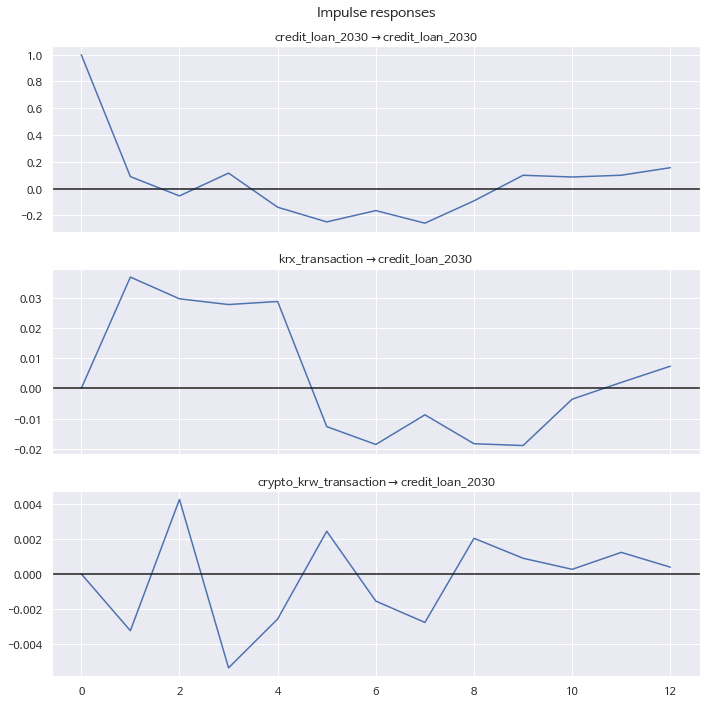

In [650]:
num_periods = 12
ir = model_fitted.irf(periods=num_periods)
#ir.plot(orth=False, plot_stderr=False, figsize=(15, 15))
ir.plot(orth=False, plot_stderr=False, response='credit_loan_2030')
None

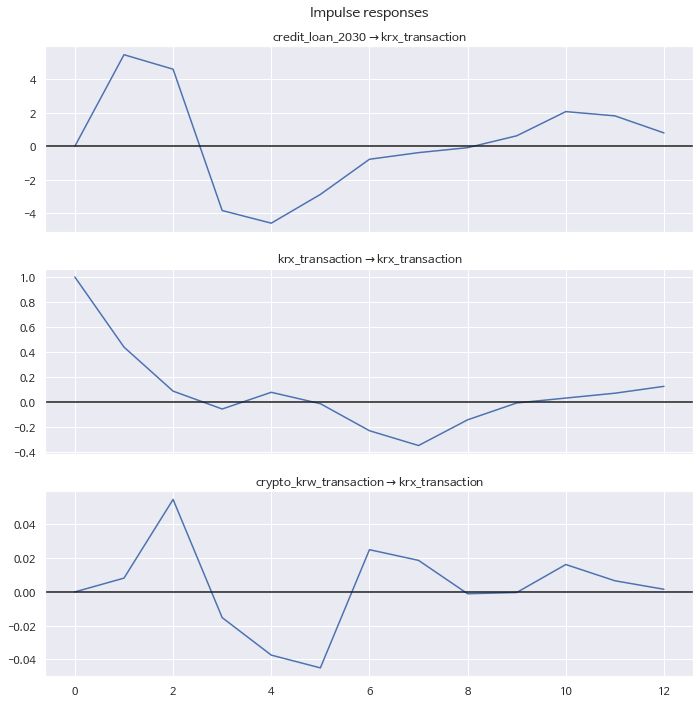

In [651]:
num_periods = 12
ir = model_fitted.irf(periods=num_periods)
#ir.plot(orth=False, plot_stderr=False, figsize=(15, 15))
ir.plot(orth=False, plot_stderr=False, response='krx_transaction')
None

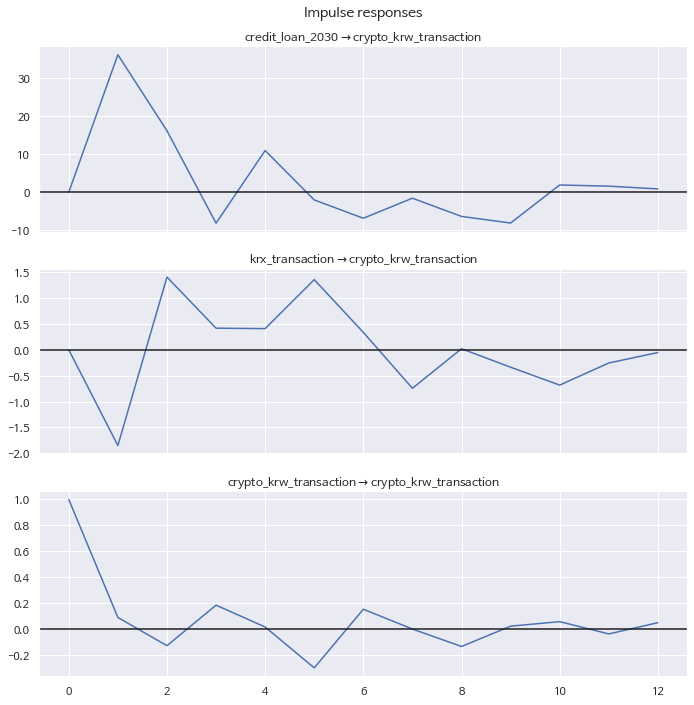

In [652]:
num_periods = 12
ir = model_fitted.irf(periods=num_periods)
#ir.plot(orth=False, plot_stderr=False, figsize=(15, 15))
ir.plot(orth=False, plot_stderr=False, response='crypto_krw_transaction')
None